In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Kaggle Api

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
import os
# Upload kaggle.json file
files.upload()

# Create the .kaggle directory if it doesn't exist
os.makedirs('/root/.kaggle', exist_ok=True)

!mv kaggle.json /root/.kaggle/

# Change the file permission to make it read-only
!chmod 600 /root/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d kushagra3204/sentiment-and-emotion-analysis-dataset

Dataset URL: https://www.kaggle.com/datasets/kushagra3204/sentiment-and-emotion-analysis-dataset
License(s): CC0-1.0
100% 14.9M/14.9M [00:01<00:00, 13.1MB/s]
100% 14.9M/14.9M [00:01<00:00, 12.9MB/s]


In [ ]:
!unzip sentiment-and-emotion-analysis-dataset.zip

Archive:  sentiment-and-emotion-analysis-dataset.zip
  inflating: archive/combined_emotion.csv  
  inflating: archive/combined_sentiment_data.csv  


In [ ]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import spacy

In [ ]:
emotion_data = pd.read_csv("archive/combined_emotion.csv")

In [ ]:
emotion_data.head()

,sentence,emotion
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear


## EDA

In [ ]:
emotion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422746 entries, 0 to 422745
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  422746 non-null  object
 1   emotion   422746 non-null  object
dtypes: object(2)
memory usage: 6.5+ MB


In [ ]:
# Check for missing values
emotion_data.isnull().sum()

,0
sentence,0
emotion,0


In [ ]:
# check the distribution of the target classes
emotion_data['emotion'].value_counts()

,count
emotion,
joy,143067
sad,121187
anger,59317
fear,49649
love,34554
suprise,14972


In [ ]:
print(emotion_data.duplicated().sum())

6623


In [ ]:
emotion_data_cleaned = emotion_data.drop_duplicates()

In [ ]:
emotion_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 416123 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  416123 non-null  object
 1   emotion   416123 non-null  object
dtypes: object(2)
memory usage: 9.5+ MB


<Axes: title={'center': 'distribution of Emotion'}, xlabel='emotion'>

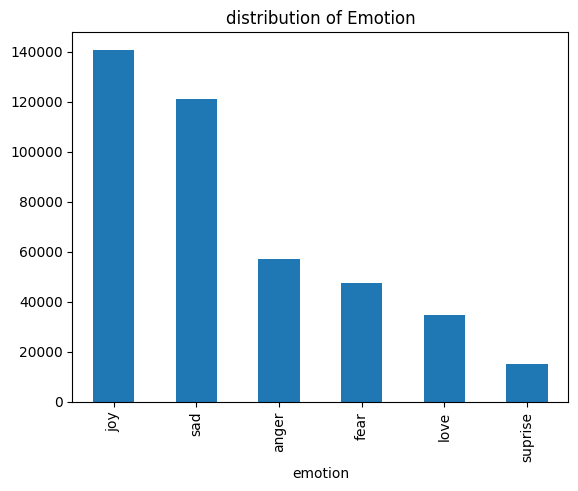

In [ ]:
emotion_data_cleaned['emotion'].value_counts().plot(kind='bar', title="distribution of Emotion")

## Preprocess Data

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize, remove stopwords, and lemmatize using spaCy
    doc = nlp(text)
    words = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(words)

In [ ]:
emotion_sentences = emotion_data_cleaned.iloc[:, 0].apply(preprocess_text)
emotion_labels = emotion_data_cleaned.iloc[:, 1]

In [ ]:
import pickle

# Save the processed data (sentences and labels) as a pickle file
with open('/content/drive/MyDrive/emotion_data.pkl', 'wb') as f:
    pickle.dump((emotion_sentences, emotion_labels), f)

## Train a baseline

In [ ]:
# Split into train and test
emotion_X_train, emotion_X_test, emotion_y_train, emotion_y_test = train_test_split(
    emotion_sentences, emotion_labels, test_size=0.2, random_state=42
)

# Split the training data into train and validation
emotion_X_train, emotion_X_val, emotion_y_train, emotion_y_val = train_test_split(
    emotion_X_train, emotion_y_train, test_size=0.2, random_state=42
)

In [ ]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [ ]:
pipeline.fit(emotion_X_train, emotion_y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
Rf_predictions = pipeline.predict(emotion_X_val)

In [ ]:
print("Emotion data Classification Report:")
print(classification_report(emotion_y_val, Rf_predictions))

Emotion data Classification Report:
              precision    recall  f1-score   support

       anger       0.87      0.87      0.87      9112
        fear       0.80      0.80      0.80      7640
         joy       0.87      0.90      0.89     22629
        love       0.71      0.63      0.67      5519
         sad       0.91      0.91      0.91     19321
     suprise       0.68      0.66      0.67      2359

    accuracy                           0.86     66580
   macro avg       0.81      0.80      0.80     66580
weighted avg       0.86      0.86      0.86     66580



## Train Neural network

In [2]:
import pickle
# To load back the data
with open('/content/drive/MyDrive/emotion_data.pkl', 'rb') as f:
    emotion_sentences, emotion_labels = pickle.load(f)

In [3]:
from torch.utils.data import Dataset
import torch

class EmotionDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len=128):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, item):
        sentence = self.sentences[item]
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [5]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import pandas as pd
from sklearn.preprocessing import LabelEncoder


# Encode the labels
label_encoder = LabelEncoder()
emotion_labels_encoded = label_encoder.fit_transform(emotion_labels)

# Check the class distribution of encoded labels
data = pd.DataFrame({'sentence': emotion_sentences, 'label': emotion_labels_encoded})

# Print class distribution before under-sampling
print("Class Distribution (Encoded) Before Resampling:")
print(data['label'].value_counts())

# Find the largest class size
class_distribution = data['label'].value_counts()
print("Class Distribution (Encoded) Before Resampling:")
print(class_distribution)

# Find the smallest class size (to target it for balancing)
minority_class_size = class_distribution.min()

# Perform under-sampling to balance the classes: Resample majority class
# Define the target size for the majority classes
target_majority_size = minority_class_size

# Separate the classes
balanced_data = []

# For each class, resample the majority class (or use the minority class size)
for label, group in data.groupby('label'):
    if len(group) > minority_class_size:
        # If the class is larger than the smallest class, downsample it
        downsampled = resample(group, replace=False, n_samples=minority_class_size, random_state=42)
        balanced_data.append(downsampled)
    else:
        # If the class is already smaller or equal to the minority class, keep it as is
        balanced_data.append(group)

# Combine the downsampled majority class with the minority class
balanced_data = pd.concat(balanced_data)

# Shuffle the resulting dataset to avoid any bias
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Get the balanced sentences and labels
balanced_sentences = balanced_data['sentence'].tolist()
balanced_labels = balanced_data['label'].tolist()

# Output the balanced class distribution
balanced_class_distribution = pd.Series(balanced_labels).value_counts()
print("Balanced Class Distribution:")
print(balanced_class_distribution)


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# let's split the data into train, validation, and test sets
emotion_X_train, emotion_X_test, emotion_y_train, emotion_y_test = train_test_split(
    balanced_sentences, balanced_labels, test_size=0.2, random_state=42
)

# Further split the training data into train and validation sets
emotion_X_train, emotion_X_val, emotion_y_train, emotion_y_val = train_test_split(
    emotion_X_train, emotion_y_train, test_size=0.2, random_state=42
)

max_len = 64  # Limit sequence length to 64 tokens
train_dataset = EmotionDataset(balanced_sentences, balanced_labels, tokenizer, max_len=max_len)
val_dataset = EmotionDataset(emotion_X_val, emotion_y_val, tokenizer, max_len=max_len)

# Step 3: Train model with the reduced dataset and sequence length
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

training_args = TrainingArguments(
    output_dir='content/drive/results/',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',  # Change to accuracy for best model selection
    report_to="none",  # Disable W&B logging
)

# Updated compute_metrics function for accuracy
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(axis=-1))}  # Use accuracy here
)

Class Distribution (Encoded) Before Resampling:
label
2    140779
4    120989
0     57235
1     47664
3     34497
5     14959
Name: count, dtype: int64
Class Distribution (Encoded) Before Resampling:
label
2    140779
4    120989
0     57235
1     47664
3     34497
5     14959
Name: count, dtype: int64
Balanced Class Distribution:
4    14959
3    14959
0    14959
2    14959
1    14959
5    14959
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.184300,0.167681,0.947288
2,0.136600,0.108321,0.956131
3,0.101800,0.098122,0.959125


TrainOutput(global_step=16830, training_loss=0.1916863349103106, metrics={'train_runtime': 3751.4311, 'train_samples_per_second': 71.776, 'train_steps_per_second': 4.486, 'total_flos': 8856044171509248.0, 'train_loss': 0.1916863349103106, 'epoch': 3.0})

In [ ]:
# Evaluate
results = trainer.evaluate()
print(results)

{'eval_loss': 0.09812165051698685, 'eval_accuracy': 0.9591254090940742, 'eval_runtime': 56.7174, 'eval_samples_per_second': 253.203, 'eval_steps_per_second': 3.967, 'epoch': 3.0}


## Use The Model

In [ ]:
from transformers import BertForSequenceClassification

# Define the path to the checkpoint you want to load
checkpoint_path = 'content/drive/results/checkpoint-16830'

# Load the model from the checkpoint
model = BertForSequenceClassification.from_pretrained(checkpoint_path)

# load the tokenizer (for text processing)
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Select a sample sentence from the validation set
sample_sentence = emotion_X_val[0]  # Example: first sentence in validation
true_label = emotion_y_val[0]  # Corresponding true label

In [ ]:
from torch.nn.functional import softmax


# Tokenize the sample sentence
inputs = tokenizer(sample_sentence, return_tensors="pt", padding=True, truncation=True, max_length=64)

# Perform inference
outputs = model(**inputs)
logits = outputs.logits

# Apply softmax to get probabilities
probabilities = softmax(logits, dim=-1)

# Convert the probabilities tensor to a numpy array for easier handling
probabilities = probabilities.detach().numpy().flatten()  # Convert to NumPy array

# Map the class indices to their corresponding labels using the label_encoder
label_names = label_encoder.classes_

# Zip the probabilities with the corresponding label names
probability_label_pairs = list(zip(label_names, probabilities))

In [ ]:
# Print the class probabilities along with the labels
for label, prob in probability_label_pairs:
    print(f"Class: {label}, Probability: {prob:.4f}")

Class: anger, Probability: 0.0001
Class: fear, Probability: 0.0000
Class: joy, Probability: 0.0000
Class: love, Probability: 0.0000
Class: sad, Probability: 0.9998
Class: suprise, Probability: 0.0000


## Save the model in Google Drive

In [ ]:
# Save the trained model to Google Drive
model.save_pretrained('/content/drive/MyDrive/checkpoint-16830')